##Курсовой проект
Основная метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:

1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на программу в github или kaggle notebook.
2. Необходимо получить R2>0.6

Примечание: Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Подключение бибилиотек и скриптов

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from scipy import stats

import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
def optimizing_df(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')

        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')

    return df

Загрузка данных

In [4]:
train = pd.read_csv('/content/sample_data/train.csv')
test = pd.read_csv('/content/sample_data/test.csv')

Описание датасета

**Id** - идентификатор квартиры

**DistrictId**	- идентификатор района

**Rooms** - количество комнат

**Square** - площадь

**LifeSquare** - жилая площадь

**KitchenSquare** - площадь кухни

**Floor** - этаж

**HouseFloor** - количество этажей в доме

**HouseYear** - год постройки дома

**Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности

**Social_1, Social_2, Social_3** - социальные показатели местности

**Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья

**Shops_1, Shops_1** - показатели, связанные с наличием магазинов, торговых центров

**Price** - цена квартиры

In [5]:
print(f"Train:\t{train.shape[0]}\t sales and {train.shape[1]} features")
print(f'Test:\t{test.shape[0]}\t sales and {test.shape[1]} features')

Train:	10000	 sales and 20 features
Test:	5000	 sales and 19 features


In [6]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [7]:
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


Проверка данных

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [11]:
train['Rooms'] = train['Rooms'].astype('int64')
test['Rooms'] = test['Rooms'].astype('int64')

train['HouseFloor'] = train['HouseFloor'].astype('int64')
test['HouseFloor'] = test['HouseFloor'].astype('int64')

array([[<Axes: title={'center': 'Id'}>,
        <Axes: title={'center': 'DistrictId'}>,
        <Axes: title={'center': 'Rooms'}>,
        <Axes: title={'center': 'Square'}>],
       [<Axes: title={'center': 'LifeSquare'}>,
        <Axes: title={'center': 'KitchenSquare'}>,
        <Axes: title={'center': 'Floor'}>,
        <Axes: title={'center': 'HouseFloor'}>],
       [<Axes: title={'center': 'HouseYear'}>,
        <Axes: title={'center': 'Ecology_1'}>,
        <Axes: title={'center': 'Ecology_2'}>,
        <Axes: title={'center': 'Ecology_3'}>],
       [<Axes: title={'center': 'Social_1'}>,
        <Axes: title={'center': 'Social_2'}>,
        <Axes: title={'center': 'Social_3'}>,
        <Axes: title={'center': 'Healthcare_1'}>],
       [<Axes: title={'center': 'Helthcare_2'}>,
        <Axes: title={'center': 'Shops_1'}>,
        <Axes: title={'center': 'Shops_2'}>,
        <Axes: title={'center': 'Price'}>]], dtype=object)

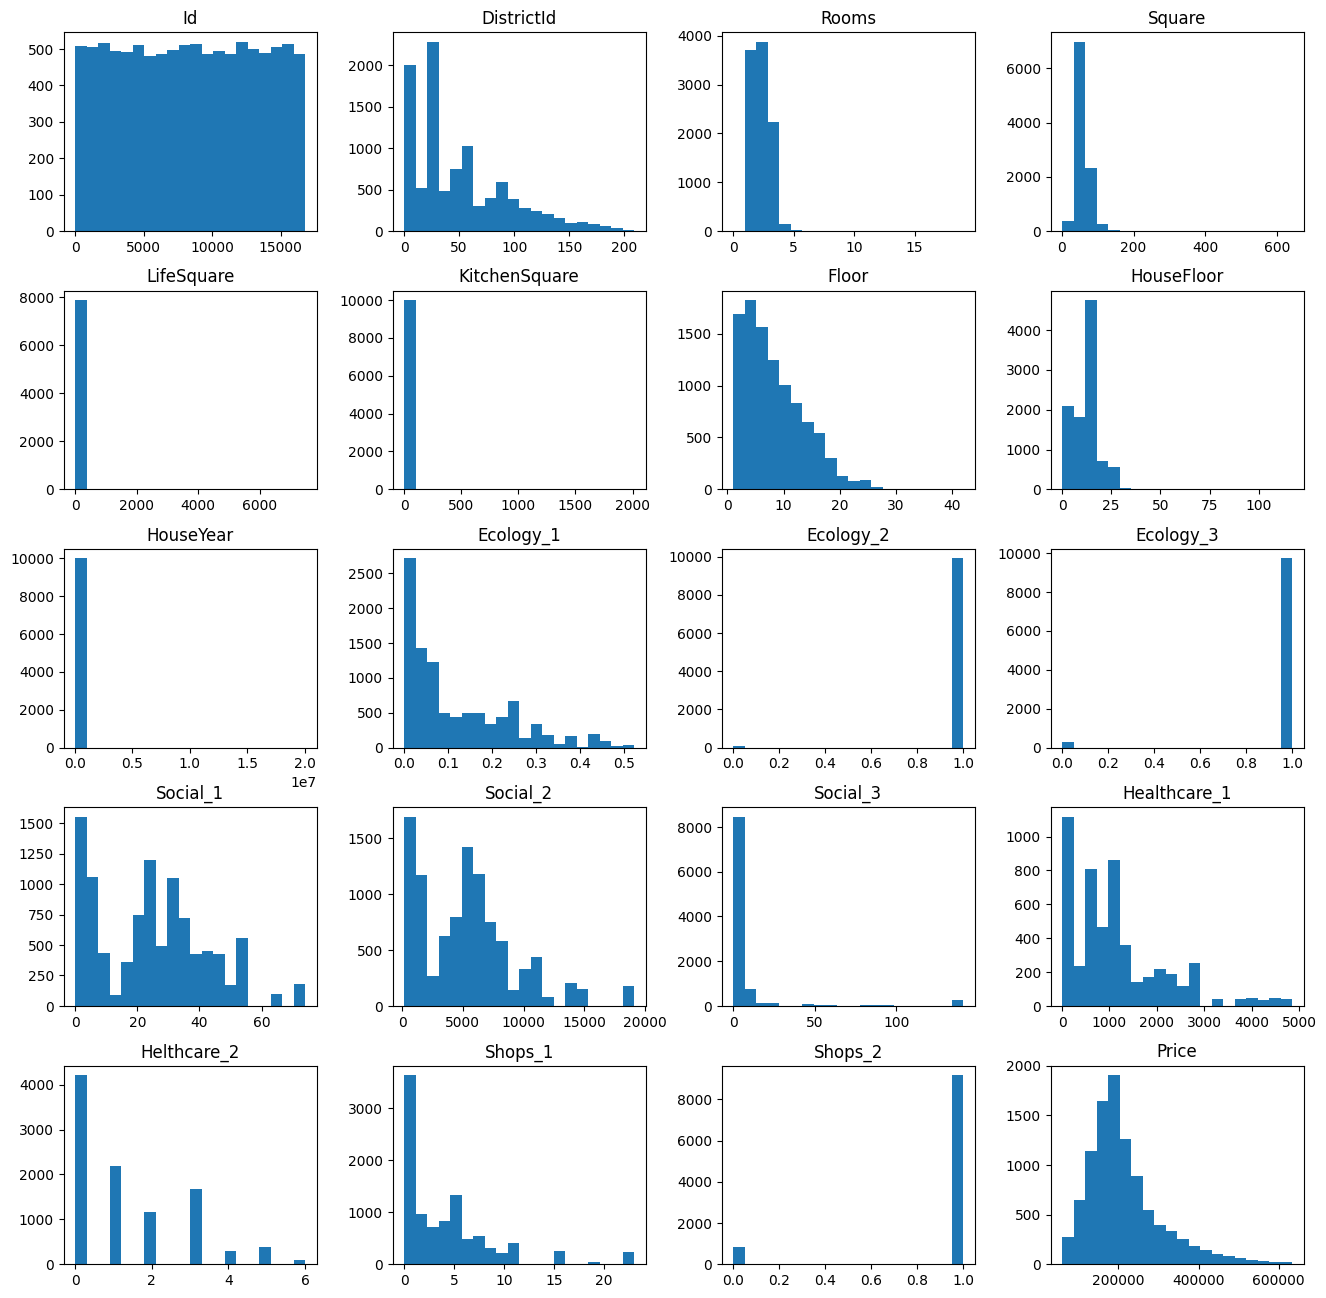

In [98]:
train.hist(figsize=(16,16), bins=20, grid=False)

In [24]:
all_data = pd.concat((train, test), sort=False).reset_index(drop=True)
all_data.drop(['Price'], axis=1, inplace=True)
print(f'all_data size is : {all_data.shape}')

all_data size is : (15000, 19)


In [12]:
all_data = pd.concat((train, test), sort=False).reset_index(drop=True)
all_data.drop(['Price'], axis=1, inplace=True)
print(f'all_data size is : {all_data.shape}')

all_data size is : (15000, 19)


In [13]:
all_data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,15000.000000,15000.000000,15000.000000,15000.000000,11846.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,7825.000000,15000.000000,15000.000000
mean,8393.136933,50.693600,1.897000,56.360350,36.851792,6.174467,8.561800,12.606600,3.321575e+03,0.119196,24.769267,5370.404933,8.113667,1144.162428,1.319467,4.235133
std,4850.111673,43.786257,0.839229,20.423913,71.120183,24.016979,5.323113,6.780165,1.637078e+05,0.119371,17.532278,4013.364403,23.841946,1029.296278,1.489012,4.796545
min,0.000000,0.000000,0.000000,1.136859,0.333490,0.000000,1.000000,0.000000,1.908000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000
25%,4188.750000,20.000000,1.000000,41.814371,22.896130,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000
50%,8378.500000,37.000000,2.000000,52.645757,32.822810,6.000000,7.000000,12.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000
75%,12594.250000,75.000000,2.000000,66.036608,45.144624,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.000000,6.000000
max,16798.000000,212.000000,19.000000,641.065193,7480.592129,2014.000000,78.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000


In [14]:
all_data.loc[all_data['Rooms'] > 6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
377,5927,57,10,59.056975,36.223072,10.0,22,22,2002,0.090799,B,B,74,19083,2,NaN,5,15,B
1454,8491,1,19,42.006046,21.779288,7.0,17,17,2014,0.007122,B,B,1,264,0,NaN,0,1,B
8849,14865,9,10,60.871266,38.420681,10.0,3,2,1994,0.161532,B,B,25,5648,1,30.0,2,4,B
13398,1435,111,17,52.866107,32.528342,8.0,15,17,1987,0.093443,B,B,23,4635,5,3300.0,2,4,B


In [15]:
all_data.loc[all_data['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1397,12638,27,0,138.427694,136.215499,0.0,4,3,2016,0.075424,B,B,11,3097,0,NaN,0,0,B
1981,7917,27,0,212.932361,211.231125,0.0,2,3,2008,0.211401,B,B,9,1892,0,NaN,0,1,B
2269,7317,27,0,41.790881,NaN,0.0,13,0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3911,770,28,0,49.483501,NaN,0.0,16,0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B
4366,456,6,0,81.491446,NaN,0.0,4,0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
4853,3224,27,0,2.377248,0.873147,0.0,1,0,1977,0.017647,B,B,2,469,0,NaN,0,0,B
6149,3159,88,0,38.697117,19.345131,9.0,9,16,1982,0.127376,B,B,43,8429,3,NaN,3,9,B
8834,9443,27,0,87.762616,85.125471,0.0,5,15,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
12406,3343,58,0,116.824201,113.692424,0.0,3,3,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
12524,10729,27,0,76.345154,42.820796,12.0,14,0,1977,0.017647,B,B,2,469,0,NaN,0,0,B


Обработка данных

In [16]:
def df_fix_room(df):
    info_by_district_id = df.groupby(['DistrictId', 'HouseYear'], as_index=False).agg(
        {'Rooms': 'sum', 'Square': 'sum'}).rename(
        columns={'Rooms': 'sum_roos_dr', 'Square': 'sum_square_dr'})

    info_by_district_id['mean_square_per_room_in_dr'] = info_by_district_id['sum_square_dr'] \
        / info_by_district_id['sum_roos_dr']
    info_by_district_id.drop(
        ['sum_square_dr', 'sum_roos_dr'], axis=1, inplace=True)

    df = pd.merge(df, info_by_district_id, on=[
                  'DistrictId', 'HouseYear'], how='left')

    df['mean_square_per_room_in_dr'] = df['mean_square_per_room_in_dr'].fillna(
        df['mean_square_per_room_in_dr'].mean())

    df.loc[df['Rooms'] > 6, 'Rooms'] \
        = (df.loc[df['Rooms'] > 6, 'Square']
           // df.loc[df['Rooms'] > 6, 'mean_square_per_room_in_dr']).astype('int')

    df.loc[df['Rooms'] == 0, 'Rooms'] \
        = (df.loc[df['Rooms'] == 0, 'Square']
           // df.loc[df['Rooms'] == 0, 'mean_square_per_room_in_dr']).astype('int')

    df.loc[df['Rooms'] == 0, 'Rooms'] = 1
    return df

In [17]:
all_data.loc[all_data['Square'] > 200].nlargest(20, 'Square')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
6977,11602,30,2,641.065193,638.163193,10.0,20,19,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B
4262,28,9,2,604.705972,NaN,1.0,17,18,1977,0.161532,B,B,25,5648,1,30.0,2,4,B
4690,2307,102,1,409.425181,410.639749,10.0,4,4,2016,0.238617,B,B,26,3889,6,705.0,3,6,B
1982,5548,86,5,275.645284,233.949309,26.0,12,37,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B
13217,4058,27,6,223.453689,104.113552,16.0,2,2,2017,0.041116,B,B,53,14892,4,NaN,1,4,B
13909,1397,76,3,221.138768,118.055342,4.0,32,48,2011,0.000000,B,B,7,1660,39,1786.0,1,5,B
1981,7917,27,0,212.932361,211.231125,0.0,2,3,2008,0.211401,B,B,9,1892,0,NaN,0,1,B
9910,16568,27,4,200.334539,201.627361,25.0,1,2,2013,0.041116,B,B,53,14892,4,NaN,1,4,B


In [18]:
def df_fix_square_manual(df):
    df.loc[df['Square'] > 400, 'Square'] = df.loc[df['Square'] > 400, 'Square'] / 10
    return df

In [19]:
def df_fix_square(df):
    info_by_district_id = df.groupby(['DistrictId', 'Rooms', 'HouseYear'], as_index=False).agg(
        {'Square': 'mean'}).rename(
        columns={'Square': 'mean_square_rooms_dr'})

    df = pd.merge(df, info_by_district_id, on=[
        'DistrictId', 'Rooms', 'HouseYear'], how='left')

    df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'Square'] \
        = df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'Rooms'] \
        * df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'mean_square_per_room_in_dr']
    return df

In [20]:
def prepare_lifesquare(df):
    df.loc[df['Square'] < df['LifeSquare'],
           'LifeSquare'] = df.loc[df['Square'] < df['LifeSquare'], 'Square']
    return df


def fillna_life_square(df):
    df['LifeSquare'] = df['LifeSquare'].fillna(df['LifeSquare'].mean())
    return df

In [21]:
all_data.loc[all_data['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1497,10814,109,1,37.265070,20.239714,9.0,9,12,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B
4189,11607,147,2,44.791836,28.360393,5.0,4,9,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B


In [22]:
def df_fix_house_year_manual(df):
    df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = int((2005 + 2011) / 2)
    df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968
    return df

In [25]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(
    all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio': all_data_na})
missing_data

,Missing Ratio
Healthcare_1,47.833333
LifeSquare,21.026667


In [26]:
def df_del_missing(df):
    df_na = (df.isnull().sum() / len(df)) * 100

    df_na = df_na.drop(
        df_na[df_na == 0].index).sort_values(ascending=False)
    df_na = list(df_na.index)
    df.drop(df_na, axis=1, inplace=True)
    return df

Кластеры

In [29]:
scaler = MinMaxScaler()

In [30]:
train_cluster = train.copy()

In [31]:
train_cluster = df_fix_house_year_manual(train_cluster)

In [32]:
train_cluster_scaled = pd.DataFrame(scaler.fit_transform(
    train_cluster.loc[:, ['HouseYear', 'Price']]), columns=['HouseYear', 'Price'])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

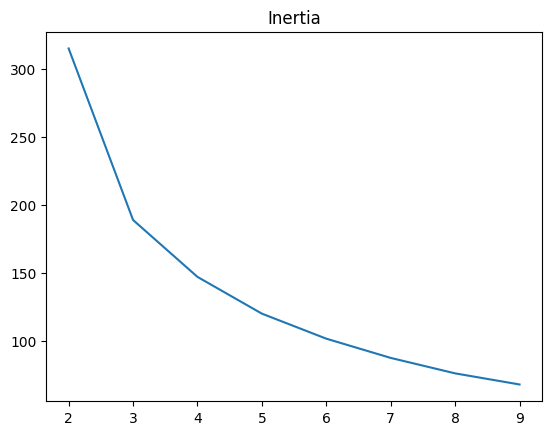

In [34]:
inertias = []

for i in range(2, 10):
    temp_model = KMeans(n_clusters=i, random_state=100)
    temp_model.fit(train_cluster_scaled)
    temp_inertia = temp_model.inertia_
    inertias.append(temp_inertia)

plt.plot(range(2, 10), inertias)
plt.title('Inertia')

plt.show()

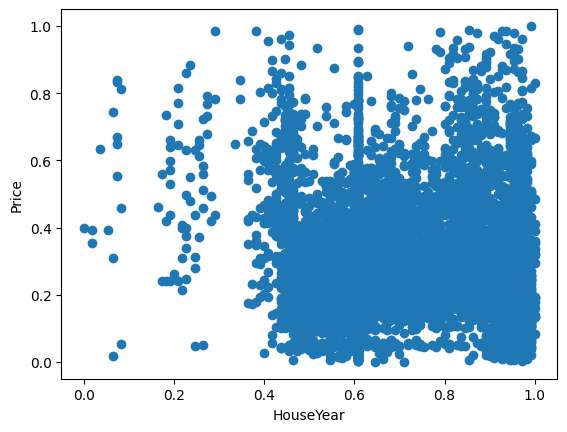

In [35]:
plt.scatter(train_cluster_scaled['HouseYear'], train_cluster_scaled['Price'])
plt.xlabel('HouseYear')
plt.ylabel('Price')
plt.show()

In [36]:
kmeans_model = KMeans(n_clusters=5, random_state=100)

In [37]:
train_labels = kmeans_model.fit_predict(train_cluster_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0.5, 1.0, 'Train data')

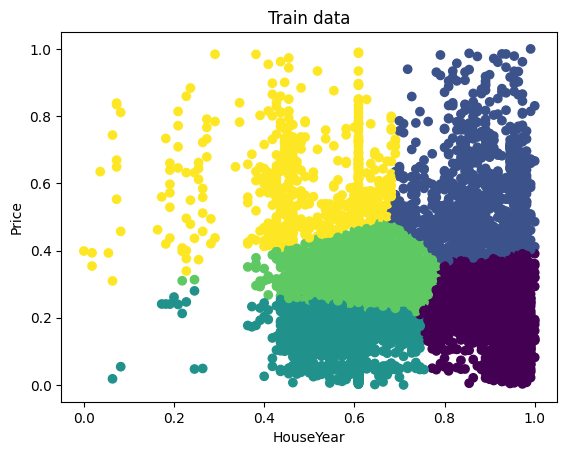

In [38]:
plt.scatter(train_cluster_scaled['HouseYear'],
            train_cluster_scaled['Price'], c=train_labels)

plt.xlabel('HouseYear')
plt.ylabel('Price')

plt.title('Train data')

In [39]:
agglomerative_clustering_model = AgglomerativeClustering(n_clusters=5)

In [40]:
train_cluster['cluster_year'] = agglomerative_clustering_model.fit_predict(
    train_cluster_scaled)

Text(0.5, 1.0, 'Train')

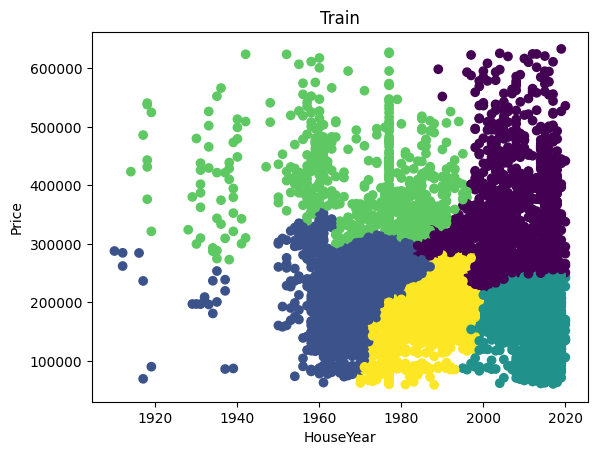

In [41]:
plt.scatter(train_cluster['HouseYear'],
            train_cluster['Price'], c=train_cluster['cluster_year'])
plt.xlabel('HouseYear')
plt.ylabel('Price')
plt.title('Train')

In [42]:
def add_cluster_year(df):
    df_scaled = pd.DataFrame(scaler.fit_transform(
        df.loc[:, ['HouseYear']]), columns=['HouseYear'])
    df['cluster_year'] = agglomerative_clustering_model.fit_predict(df_scaled)
    return df

Средняя цена по количеству комнатр и средняя цена по идентификатору района и количеству комнаи=т

In [43]:
def add_mean_price(df, df_train=train):
    price = df_train['Price'].mean()
    price_mean_by_rooms = df_train.groupby(['Rooms'], as_index=False).agg({'Price': 'mean'}).\
        rename(columns={'Price': 'mean_price_by_rooms'})

    price_mean_by_distr_rooms = df_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'mean'}).\
        rename(columns={'Price': 'mean_price_dr'})

    df = pd.merge(df, price_mean_by_distr_rooms, on=[
                  'DistrictId', 'Rooms'], how='left')
    df = pd.merge(df, price_mean_by_rooms, on='Rooms', how='left')
    df['mean_price_dr'] = df['mean_price_dr'].fillna(df['mean_price_by_rooms'])
    df['mean_price_dr'] = df['mean_price_dr'].fillna(price)
    df['mean_price_by_rooms'] = df['mean_price_by_rooms'].fillna(price)
    return df

Районы

In [44]:
def add_distr_info(df):
    distr_info = df['DistrictId'].value_counts().reset_index().\
        rename(columns={"index": "DistrictId", "DistrictId": 'large_district'})
    df = pd.merge(df, distr_info, on='DistrictId', how='left')
    df['large_district'] = df['large_district'].fillna(1)
    return df

Модель

In [46]:
def data_prepare(df, df_train=train):
    df = df_fix_square_manual(df)
    df = df_fix_house_year_manual(df)
    df = df_fix_room(df)
    df = df_fix_square(df)
    df = prepare_lifesquare(df)
    df = fillna_life_square(df)
    df = df_del_missing(df)
    df = add_cluster_year(df)
    df = add_mean_price(df, df_train)
    df = add_distr_info(df)
    df = pd.get_dummies(df)
    df.drop('mean_square_per_room_in_dr', axis=1, inplace=True)
    df.drop('mean_square_rooms_dr', axis=1, inplace=True)
    optimizing_df(df)
    return df


def model_test(model, name, test, valid):
    model_pred = model.predict(test)
    r2 = r2_score(valid, model_pred)
    mse = mean_squared_error(valid, model_pred)
    plt.scatter(valid, (model_pred - valid))
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.title(name)
    plt.legend([f'R2= {r2:.4f} and mse= {mse:.0e}'])
    plt.axhline(0, color='red')
    plt.show()


def model_top_deviation(model, test, valid):
    model_pred = model.predict(test)
    model_test = test.copy()
    model_test['Price'] = model_pred
    model_test['Price_test'] = valid
    model_test['SD'] = abs(model_test['Price']
                           - model_test['Price_test'])
    return model_test.nlargest(10, 'SD')

In [73]:
target_name = 'Price'
X = train.drop(columns=target_name)
y = train[target_name]

In [55]:
models_dict = {}

In [74]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [71]:
binary_to_numbers = {'A': 0, 'B': 1}

train['Ecology_2'] = train['Ecology_2'].replace(binary_to_numbers)
train['Ecology_3'] = train['Ecology_3'].replace(binary_to_numbers)
train['Shops_2'] = train['Shops_2'].replace(binary_to_numbers)

In [75]:
lgbm_regressor_model = LGBMRegressor()
lgbm_regressor_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1591
[LightGBM] [Info] Number of data points in the train set: 6700, number of used features: 19
[LightGBM] [Info] Start training from score 214580.938756


LGBMRegressor()

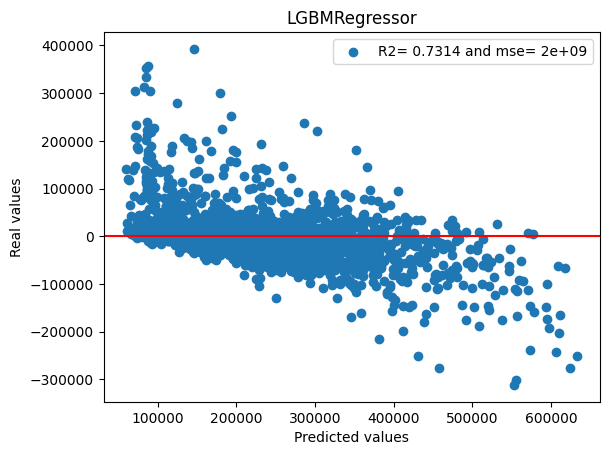

In [77]:
model_test(lgbm_regressor_model, 'LGBMRegressor', X_valid, y_valid)

In [78]:
model_top_deviation(lgbm_regressor_model, X_valid, y_valid)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Price_test,SD
132,3428,108,3,110.203969,59.270702,12.0,19,28,2007,0.019509,...,37,7687,11,176.0,5,5,1,538804.259457,146061.730565,392742.528891
9962,4660,158,2,63.131655,41.867913,8.0,9,8,1939,0.042032,...,37,6856,84,1940.0,2,5,1,444053.546106,87268.098968,356785.447138
1606,6944,143,3,78.188447,44.663408,10.0,17,16,1983,0.049863,...,18,3746,9,75.0,3,1,1,437179.713747,84808.029433,352371.684314
4442,14825,152,3,88.978324,56.939045,12.0,7,7,1958,0.042032,...,37,6856,84,1940.0,2,5,1,419817.225581,85499.969325,334317.256255
3723,203,33,4,101.554252,22.630373,9.0,4,5,1958,0.051942,...,17,4017,7,800.0,2,0,1,396026.420572,82342.775873,313683.644699
8546,8097,43,2,55.637752,32.077201,9.0,2,5,1958,0.000078,...,22,6398,141,1046.0,3,23,1,240662.737591,552515.519533,311852.781942
3000,9852,137,2,64.877319,38.682856,8.0,8,8,1956,0.200147,...,23,3975,8,770.0,2,0,1,396315.907300,90930.798420,305385.108880
696,7590,113,3,94.417148,56.749169,11.0,6,18,2008,0.050756,...,24,5469,1,145.0,0,1,1,375409.453559,71057.273346,304352.180213
6117,5632,17,3,54.036554,43.891272,8.0,6,21,2017,0.093443,...,23,4635,5,3300.0,2,4,1,254814.510799,556053.820499,301239.309700
7728,7453,24,3,126.621358,62.455481,12.0,22,48,2011,0.111627,...,50,12238,8,1970.0,2,3,1,479992.656183,179396.521035,300596.135148


Параметры модели

In [79]:
lgbm_regressor_model.get_params

<bound method LGBMModel.get_params of LGBMRegressor()>

In [80]:
np.arange(0.01, 0.05, 0.01)

array([0.01, 0.02, 0.03, 0.04])

In [81]:
parameters = [{
    'max_bin': np.arange(90, 120, 10),
    'n_estimators': np.arange(4000, 7000, 1000),
    'learning_rate': np.arange(0.01, 0.05, 0.01)
}]

In [82]:
clf = GridSearchCV(
    estimator=LGBMRegressor(random_state=42),
    param_grid=parameters,
    scoring='neg_mean_squared_error',
    cv=4,
    n_jobs=-1,
)

In [83]:
#clf.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 953
[LightGBM] [Info] Number of data points in the train set: 6700, number of used features: 19
[LightGBM] [Info] Start training from score 214580.938756


GridSearchCV(cv=4, estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'learning_rate': array([0.01, 0.02, 0.03, 0.04]),
                          'max_bin': array([ 90, 100, 110]),
                          'n_estimators': array([4000, 5000, 6000])}],
             scoring='neg_mean_squared_error')

In [84]:
#cv_results = pd.DataFrame(clf.cv_results_)
#param_columns = [
    #column
    #for column in cv_results.columns
    #if column.startswith('param_')]

#score_columns = ['mean_test_score']

#cv_results = (cv_results[param_columns + score_columns]
              .sort_values(by=score_columns, ascending=False))

#cv_results.head(10)

,param_learning_rate,param_max_bin,param_n_estimators,mean_test_score
3,0.01,100,4000,-2.326683e+09
4,0.01,100,5000,-2.341222e+09
0,0.01,90,4000,-2.345019e+09
5,0.01,100,6000,-2.354643e+09
6,0.01,110,4000,-2.355861e+09
1,0.01,90,5000,-2.364858e+09
7,0.01,110,5000,-2.376452e+09
2,0.01,90,6000,-2.380064e+09
15,0.02,110,4000,-2.391378e+09
8,0.01,110,6000,-2.394454e+09


In [85]:
clf.best_params_

{'learning_rate': 0.01, 'max_bin': 100, 'n_estimators': 4000}

In [86]:
lgbm_regressor_model = LGBMRegressor(
    max_bin=110,
    num_leaves=4,
    n_estimators=4000,
    learning_rate=0.01
)
lgbm_regressor_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1007
[LightGBM] [Info] Number of data points in the train set: 6700, number of used features: 19
[LightGBM] [Info] Start training from score 214580.938756


LGBMRegressor(learning_rate=0.01, max_bin=110, n_estimators=4000, num_leaves=4)

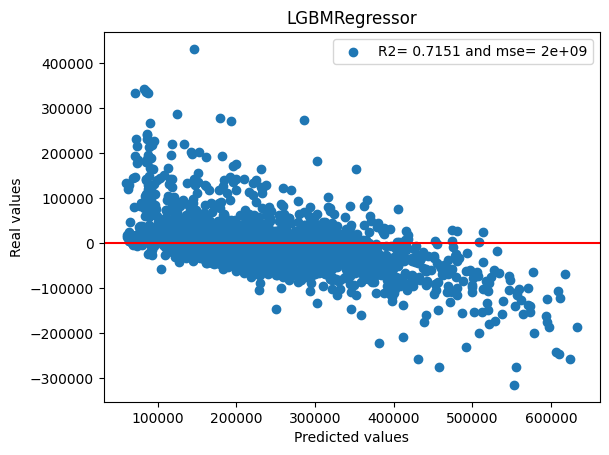

In [88]:
model_test(lgbm_regressor_model, 'LGBMRegressor', X_valid, y_valid)

In [89]:
models_dict['LGBMRegressor'] = lgbm_regressor_model

In [95]:
from sklearn.metrics import r2_score
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
  print('Train R2:\t' + str(round(r2_score(train_true_values, train_pred_values), 3)))
  print('Test R2:\t' + str(round(r2_score(test_true_values, test_pred_values), 3)))

  plt.figure(figsize=(18,10))

  plt.subplot(121)
  sns.scatterplot(x=train_pred_values, y=train_true_values)
  plt.xlabel('Predicted values')
  plt.ylabel('True values')
  plt.title('Train sample prediction')

  plt.subplot(122)
  sns.scatterplot(x=test_pred_values, y=test_true_values)
  plt.xlabel('Predicted values')
  plt.ylabel('True values')
  plt.title('Test sample prediction')

  plt.show()

Train R2:	0.792
Test R2:	0.715


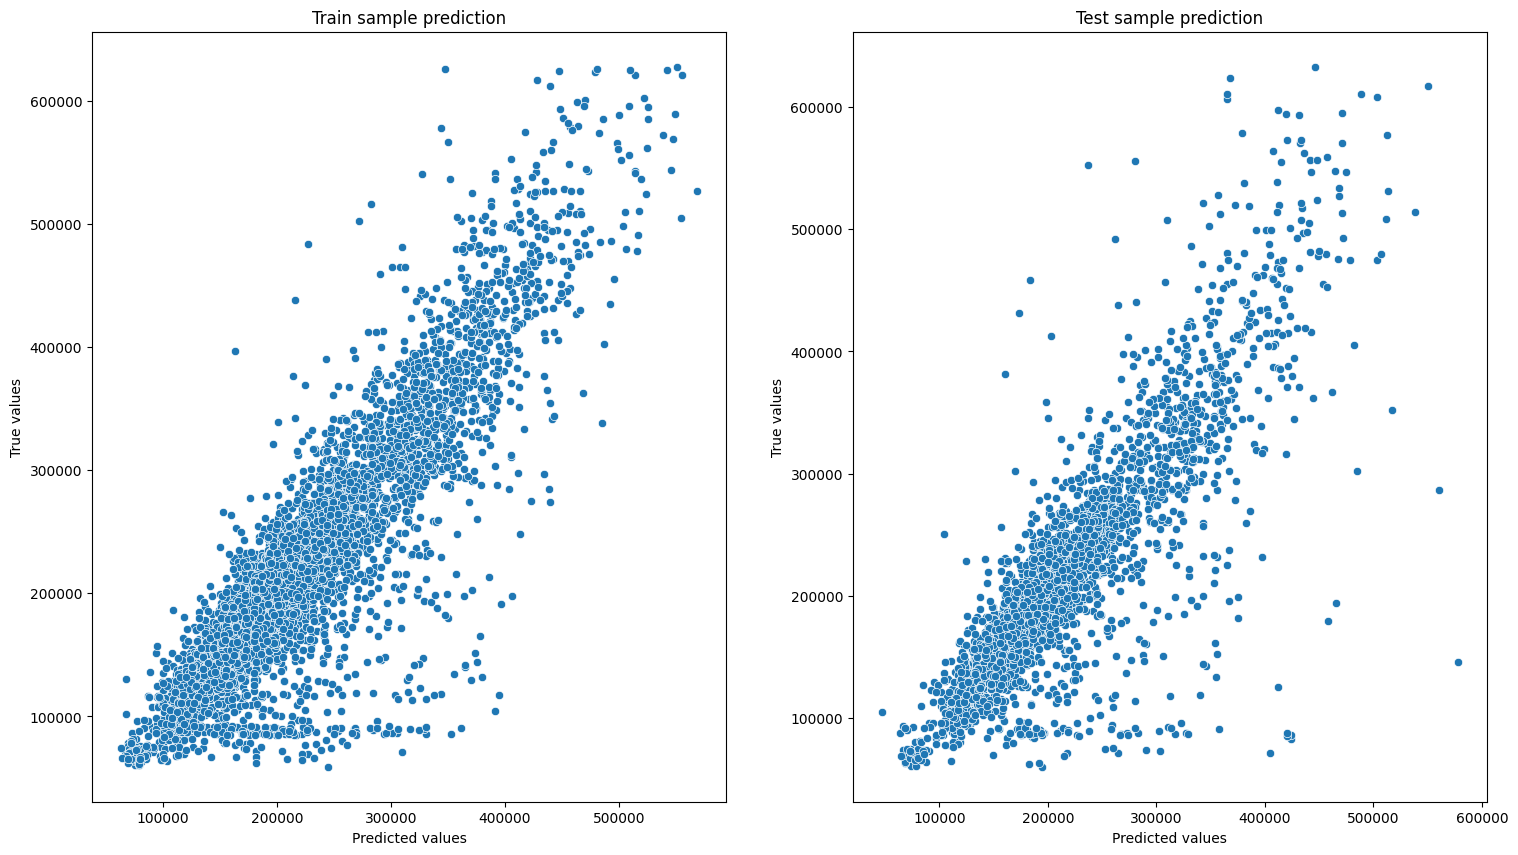

In [96]:
y_train_preds = lgbm_regressor_model.predict(X_train)
y_test_preds = lgbm_regressor_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)
